# Synthetic Natural Image Patches

A example application of the `circle_bundles` pipeline to a synthetic dataset of high-contrast $n\times n$ optical image patches sampled from a known model with the topology of a Klein bottle embedded in $\mathbb{R}^{n^{2}}$ (see --- for details). Dreimac's circular coordinates algorithm is used to produce a projection map to $\mathbb{S}^{1}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

import circle_bundles as cb

Generate the dataset and treat patches as vectors in $\mathbb{R}^{n^{2}}$:

In [2]:
n_patches = 5000  
n = 3   #Choose a patch size

rng = np.random.default_rng(0)
data = cb.sample_nat_img_kb(n_patches, n = n, rng = rng)[0]  

#Create a patch visualizer function
patch_vis = cb.make_patch_visualizer()

View a small sample of the data:

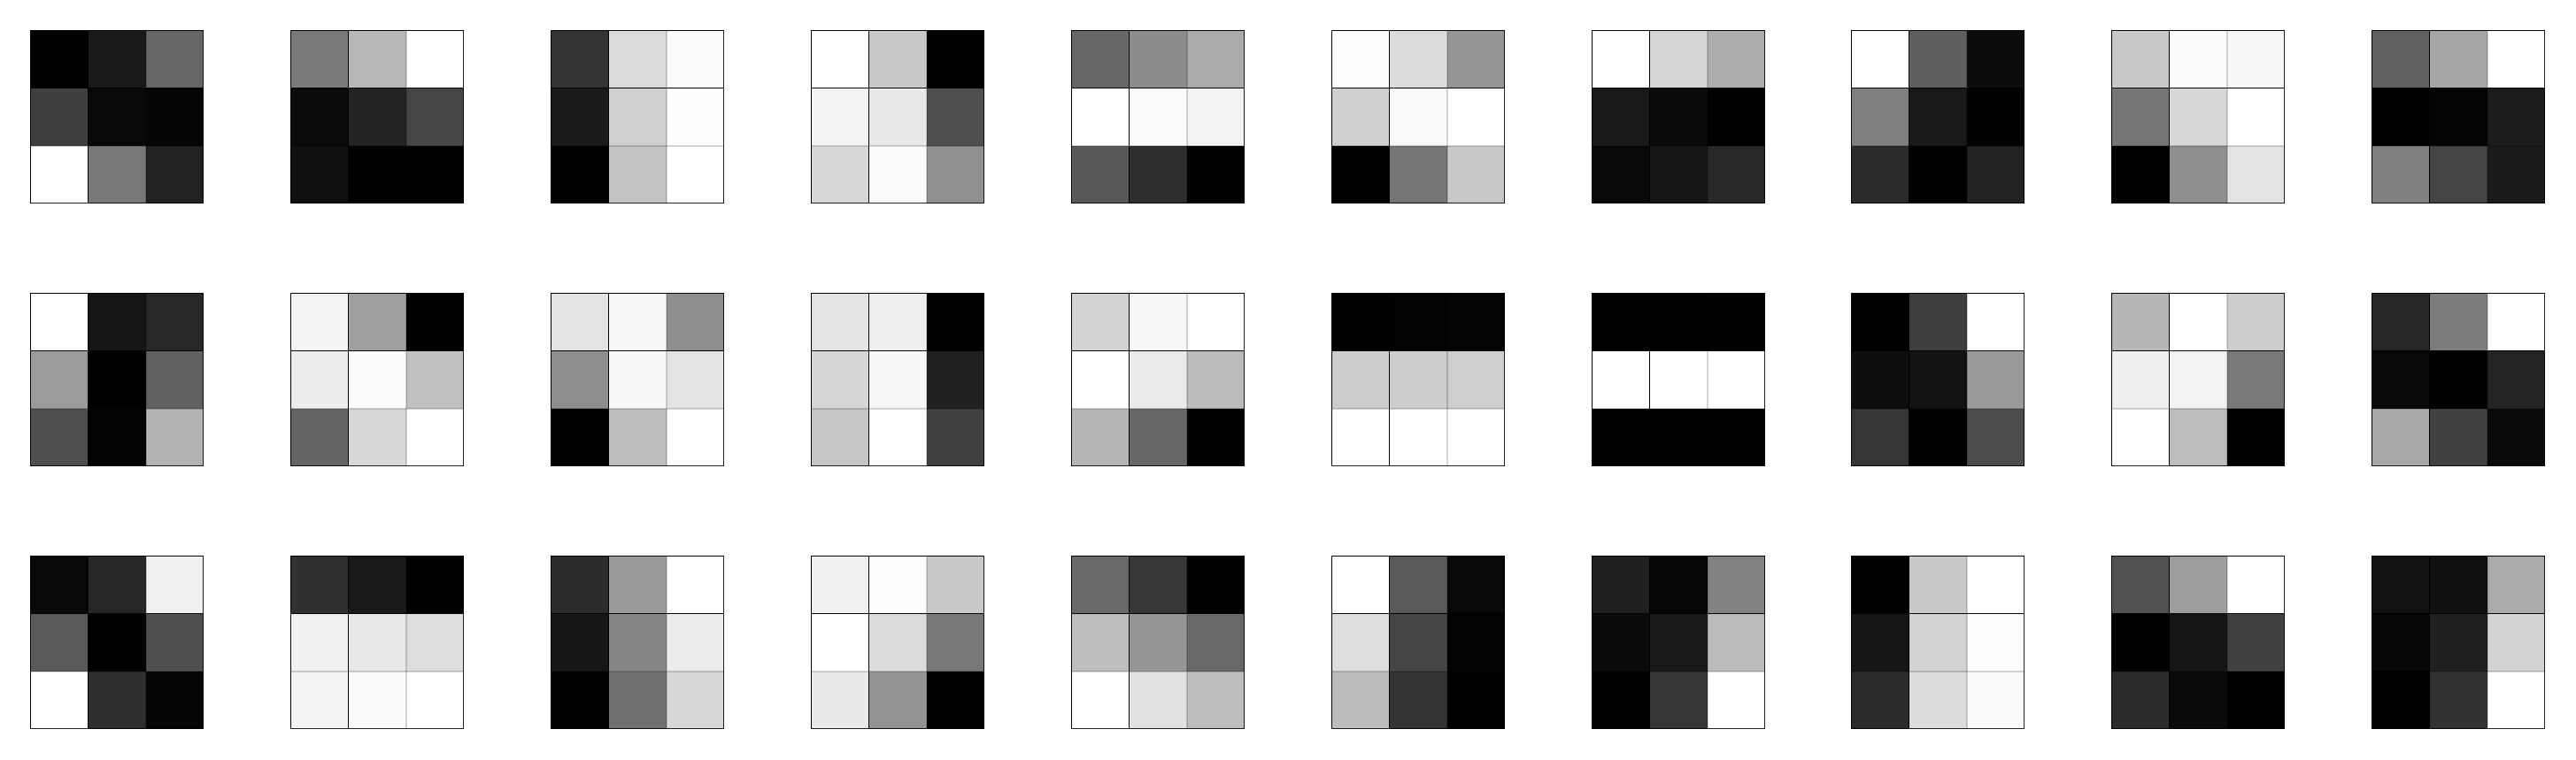

In [3]:
n_samples = 30

fig = cb.show_data_vis(
    data, 
    patch_vis, 
    max_samples = n_samples)
plt.show()


Compute persistence diagrams over $\mathbb{Z}_{2}$ and $\mathbb{Z}_{3}$ for a sample of the dataset:


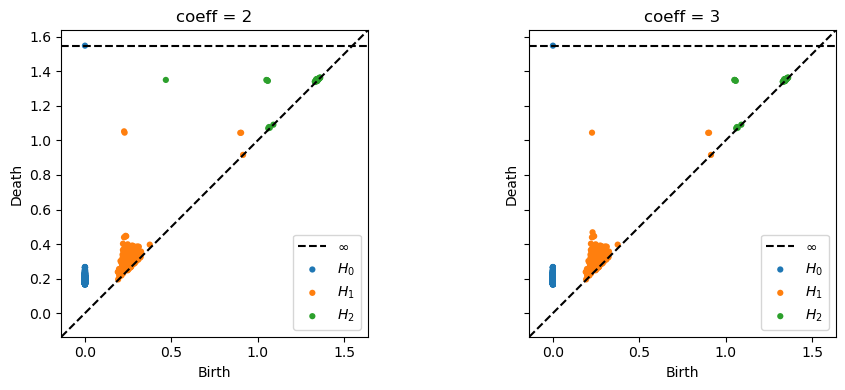

In [6]:
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


Note the $\mathbb{Z}_{2}$ diagram has two 1-dimensional persistent classes and one 2-dimensional persistent class, but the $\mathbb{Z}_{3}$ diagram has a single 1-dimensional persistent classes and no 2-dimensional persistent classes. This is consistent with the homology of the Klein bottle, as expected. 

Use Dreimac's circular coordinates algorithm to construct a projection map to $\mathbb{S}^{1}$ which captures the circular topological feature represented by the 1-dimensional $\mathbb{Z}_{3}$ persistent class:

In [6]:
from dreimac import CircularCoords

cc = CircularCoords(data, prime = 3, n_landmarks = 500)
base_angles = cc.get_coordinates()

View a small random sample of the dataset arranged by circular coordinate:

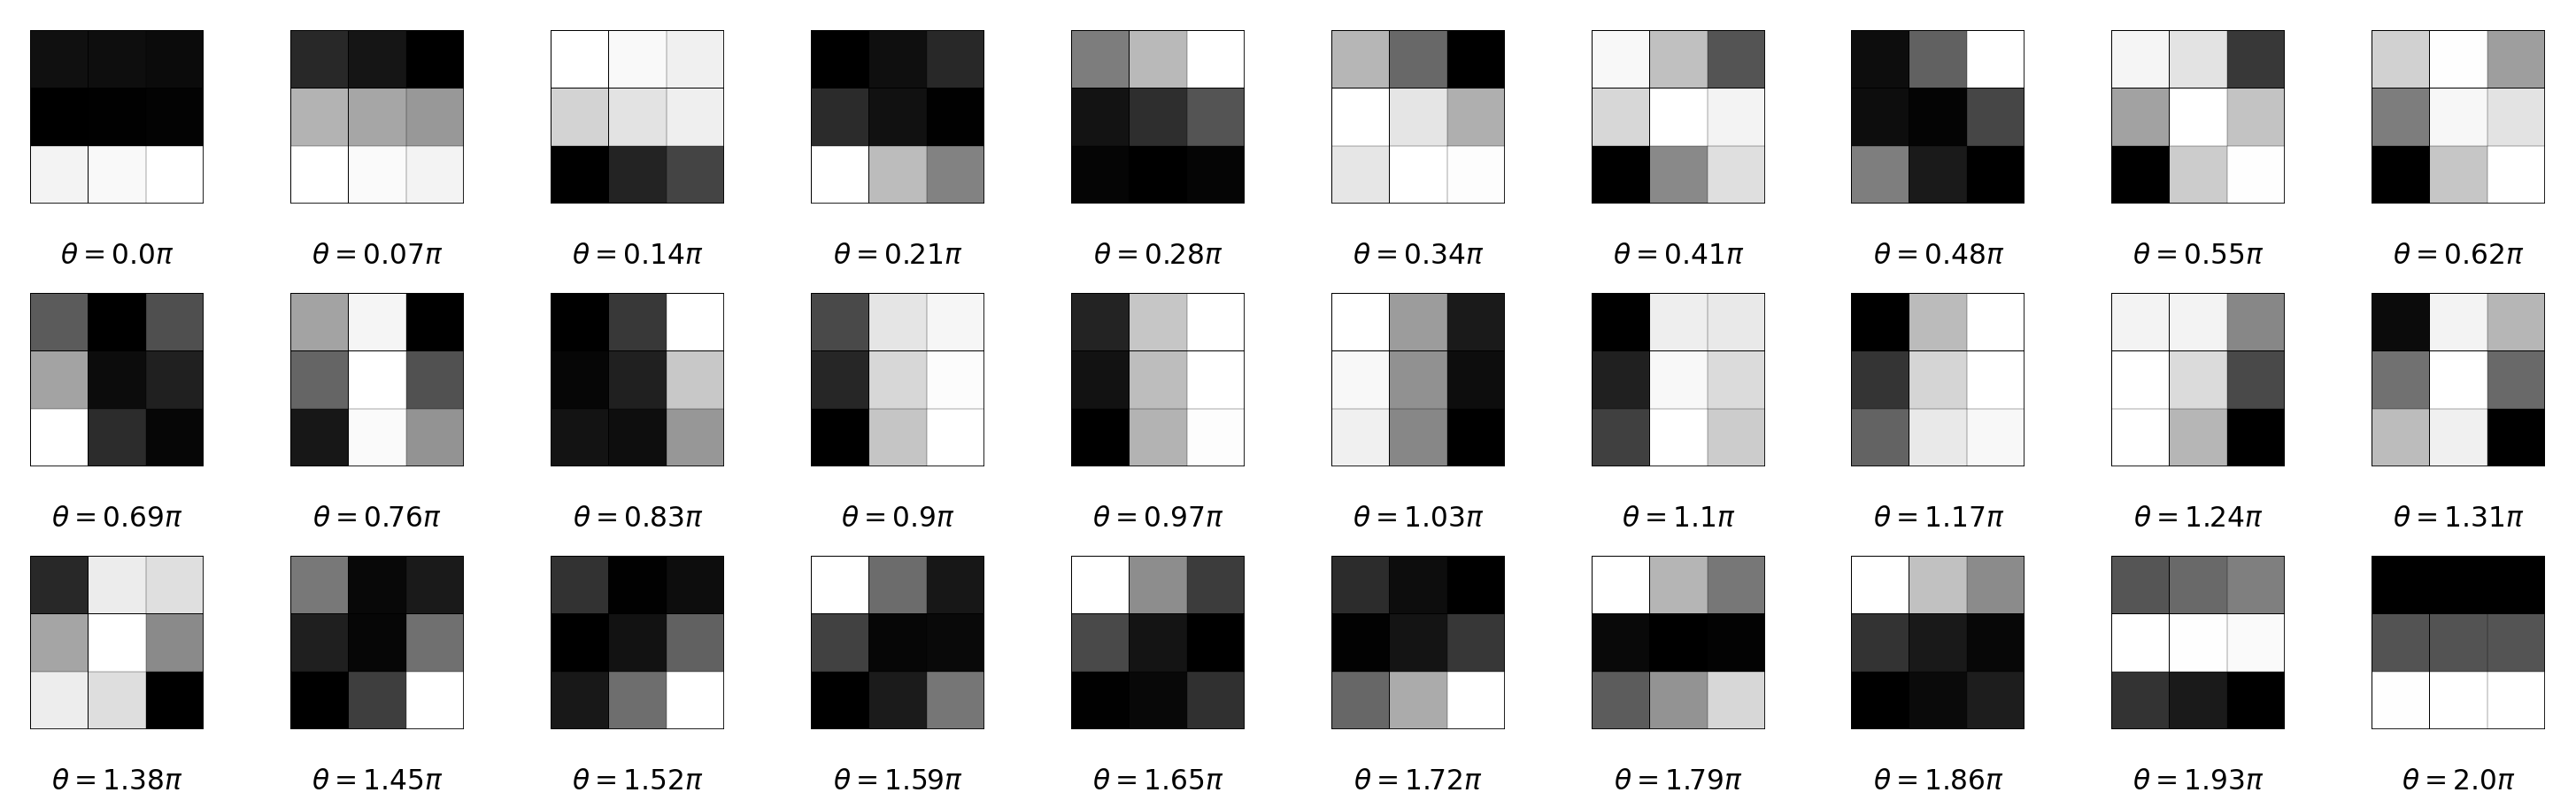

In [9]:
n_samples = 30

label_func = [fr"$\theta = {np.round(angle/np.pi, 2)}$" + r"$\pi$" for angle in base_angles]

fig = cb.show_data_vis(
    data, 
    patch_vis, 
    label_func = label_func, 
    angles = base_angles, 
    sampling_method = 'angle', 
    max_samples = n_samples)
plt.show()


Note that the assigned circular coordinates roughly correspond to the gradient directions of the patches.

Establish an open cover of $\mathbb{S}^{1} = \mathbb{R}/(2\pi\mathbb{Z})$ by metric balls around equally-spaced landmarks:

In [12]:
n_landmarks = 12
landmarks = np.linspace(0, 2*np.pi,n_landmarks, endpoint= False).reshape(-1,1)
overlap = 1.4

radius = overlap* np.pi/n_landmarks

cover = cb.get_metric_ball_cover(base_angles.reshape(-1,1), 
                                 landmarks, 
                                 radius = radius, 
                                 metric = cb.S1AngleMetric())


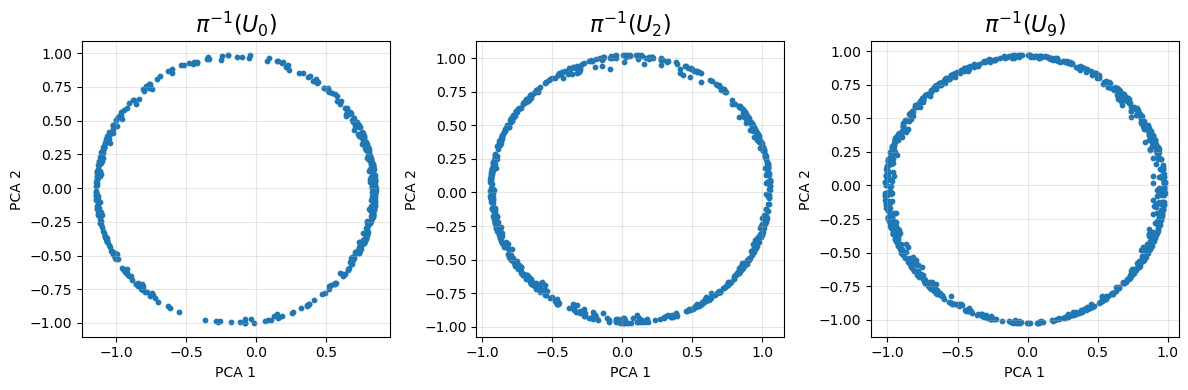

In [13]:
fiber_ids, idx_list, proj_list = cb.get_local_pca(data, cover.U, to_view = [0, 2,9])
fig, axes = cb.plot_local_pca(fiber_ids, proj_list, n_cols = 3)
plt.show()

Observe that each $\pi^{-1}(U_{j})$ appears to be concentrated around the unit circle in a plane, supporting the hypothesis that the data has the structure of a discrete approximate circle bundle over $\mathbb{S}^{1}$. Up to isomorphism, the only circle bundles over $\mathbb{S}^{1}$ are the torus (trivial) and the Klein bottle (non-orientable). These two possibilities are distinguished by the orientation class $w_{1}$.

Construct a bundle object. Use PCA2 to compute local circular coordinates:

In [14]:
bundle = cb.Bundle(X = data, cover = cover)
triv_result = bundle.get_local_trivs(show_summary = True)

<IPython.core.display.Math object>

Now, compute characteristic class info:

In [15]:
class_result = bundle.get_classes(show_summary = True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The results above confirm the non-trivial global structure, so a global trivialization is not possible here. On the other hand, as indicated by the class persistence table, the $w_{1}$ class representative restricts to a coboundary once an edge is removed from the nerve of the cover (indeed, any cocycle is a coboundary on this subcomplex). 

Remove an edge from the nerve of the open cover (corresponding to the set intersection with the poorest Procrustes alignment quality), and compute coordinates which reflect this cut:  

In [16]:
global_triv_result = bundle.get_global_trivialization()

Show a visualization of the nerve of the open cover with edges decorated by the values of the computed orientation cocycle representative (shown in blue).  The 'weight' assigned to each edge, measuring the quality of Procrustes alignment on the corresponding set intersection, is shown. The edge which was removed for coordinatization is indicated, and a potential for the orientation cocycle after restriction to the reduced nerve is shown in red: 

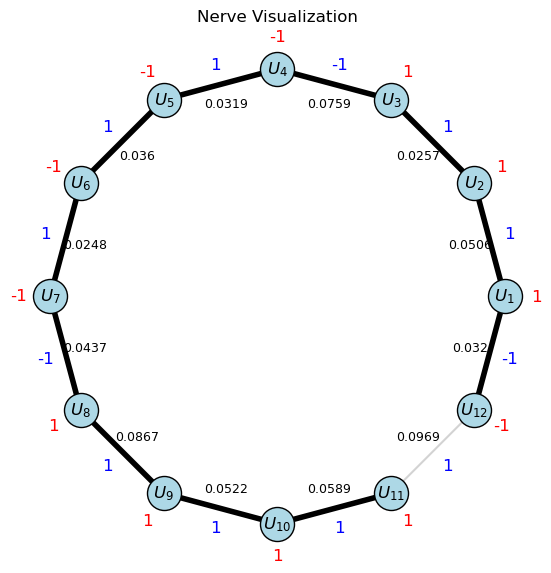

In [17]:
fig = bundle.show_circle_nerve()
plt.show()

Now, show a sample of coordinatized patches from the dataset:

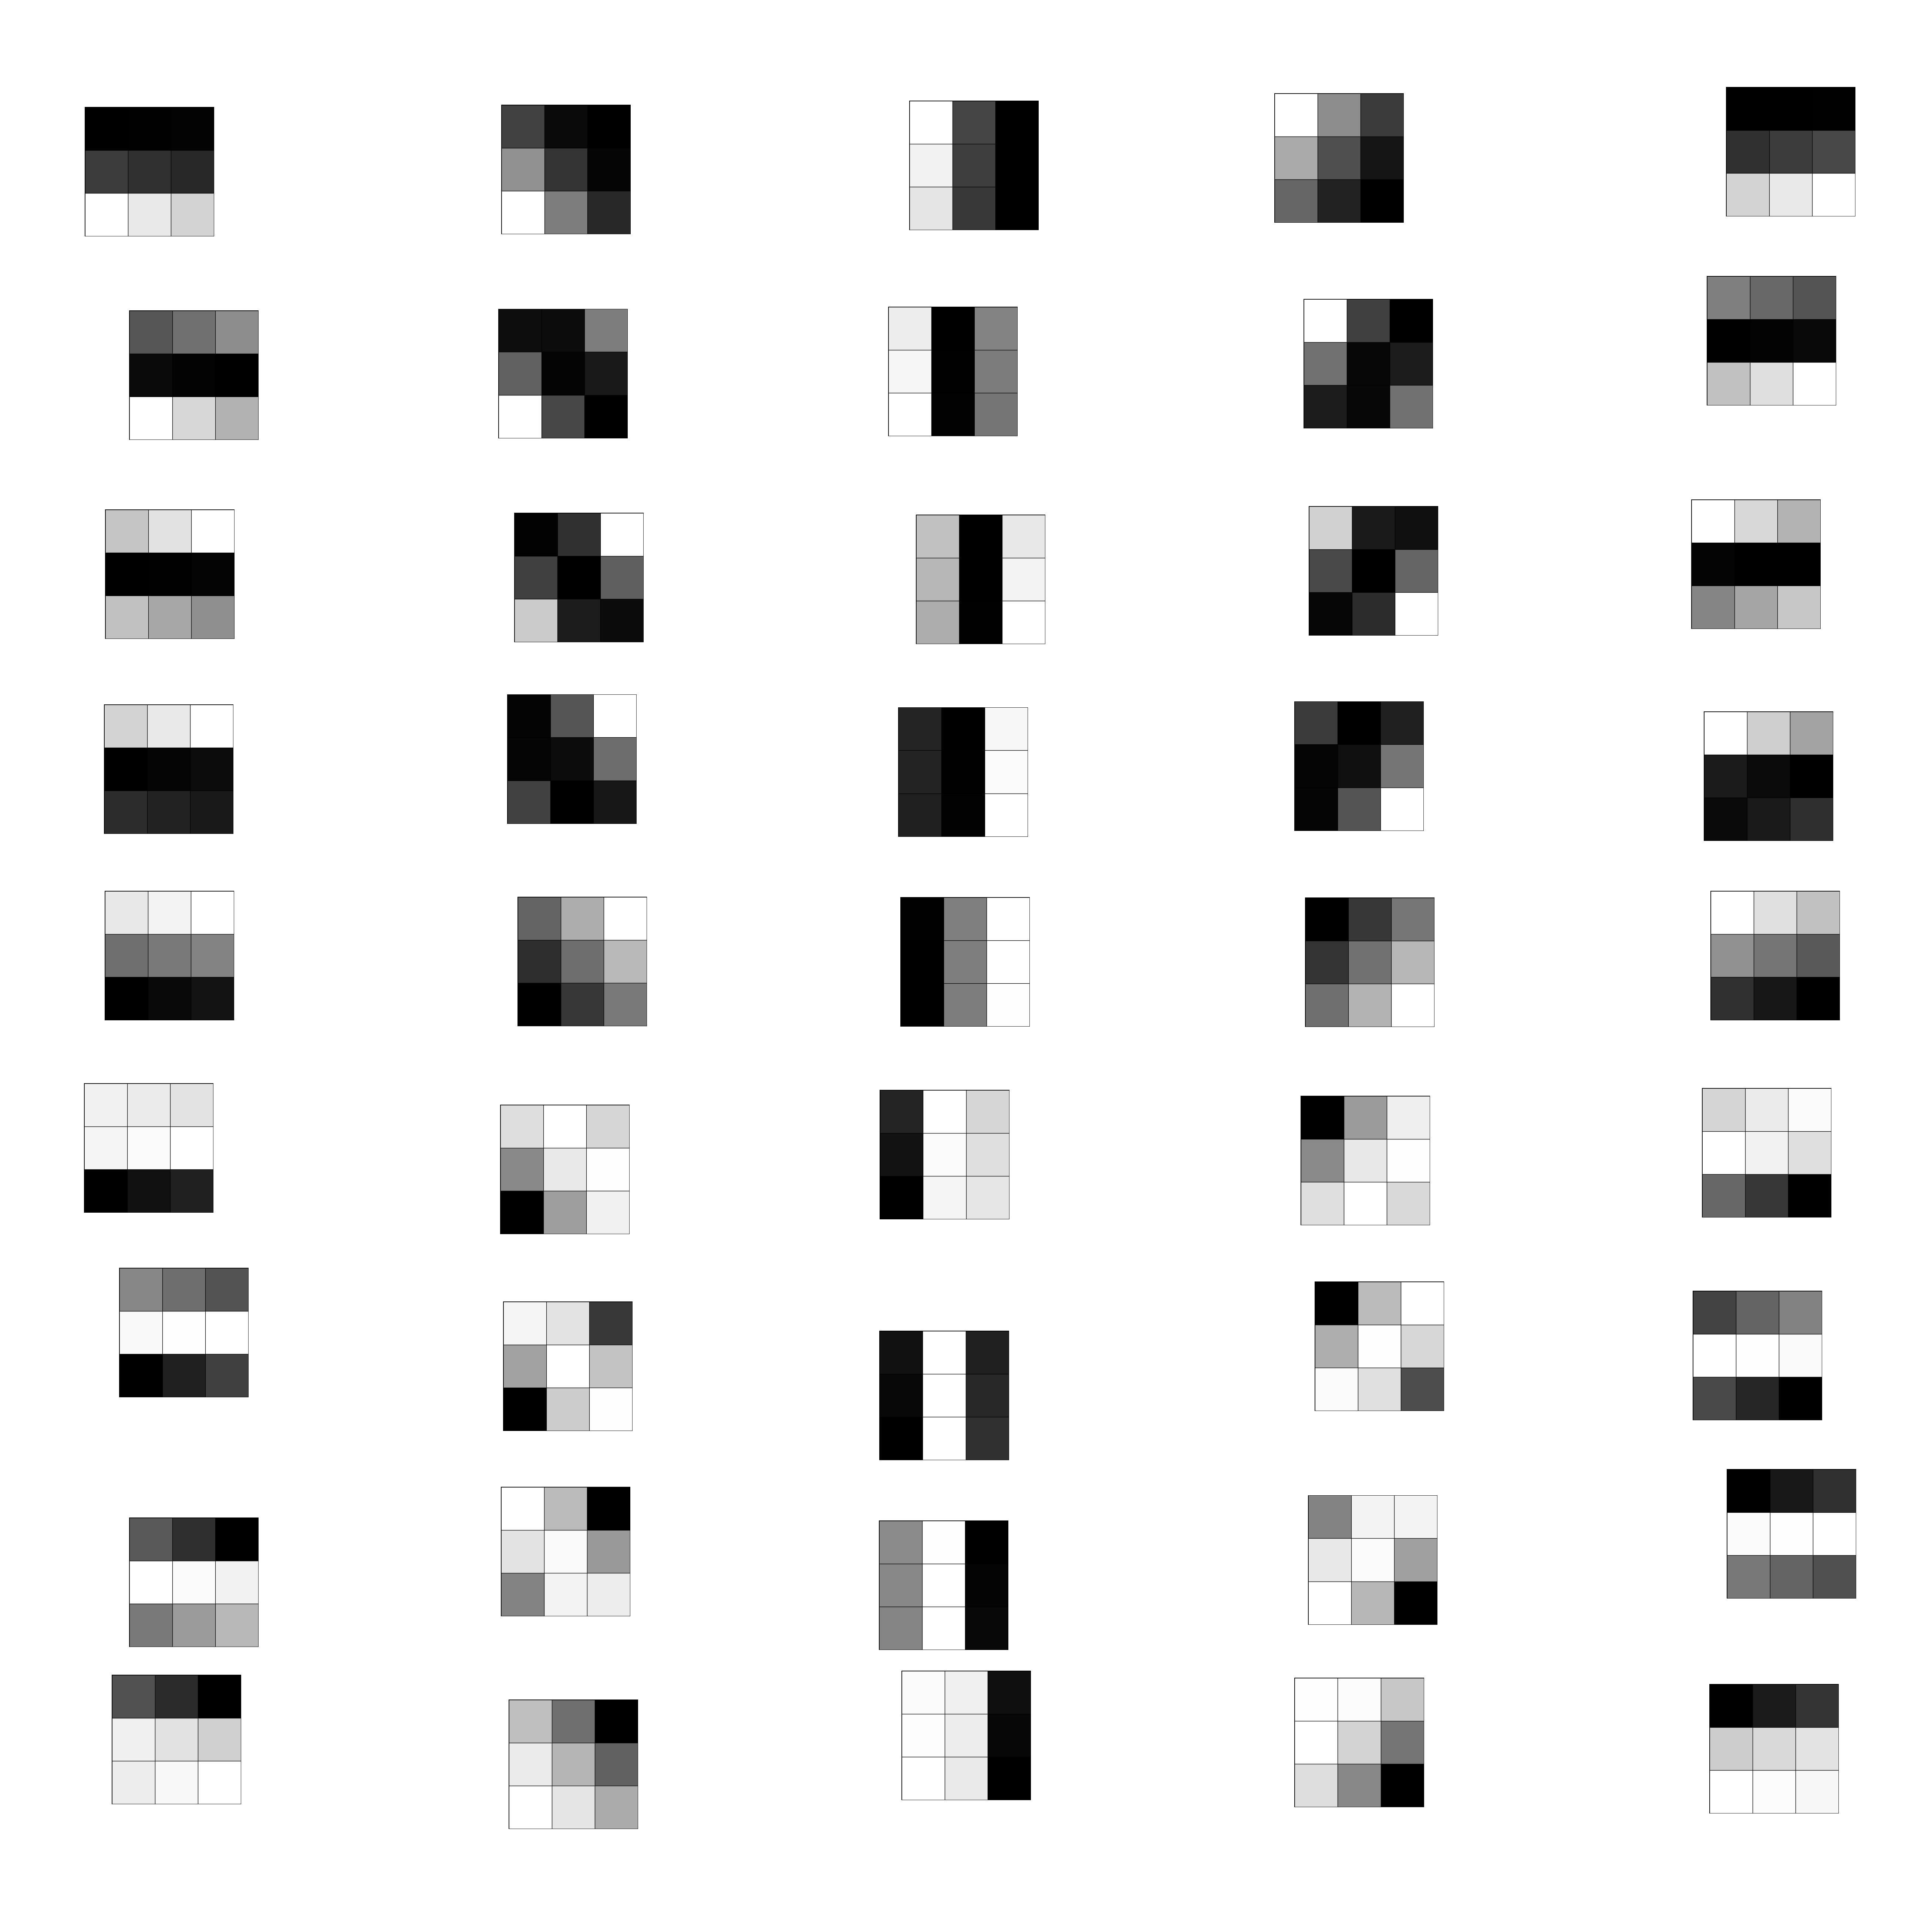

In [18]:
per_row = 5
per_col = 9
coords = np.column_stack([grad_dirs.reshape(-1,1), global_triv_result.reshape(-1,1)])

fig = cb.lattice_vis(
    data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350         
)

plt.show()


Notice the abrupt reflection in the coordinates between columns 4 and 5 in the diagram above. Everywhere else, the coordinate system varies continuously, and the edges of the diagram roughly coincide. 